In [1]:
%matplotlib inline

In [2]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, clear_output

Введем некоторые константы

In [3]:
NUM_LABELS = 10
SEED = 42
INPUT_DIR = "./" # путь до данных для обучения
OUTPUT_FNAME = "mySubmission.csv" # здесь должно быть записано имя выходного файла с ответами модели
CLS_LIST = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Загрузим данные для обучения и теста

In [4]:
X = np.load(f"{INPUT_DIR}/x_train.npy")
y = np.load(f"{INPUT_DIR}/y_train.npy")
X_val = np.load(f"{INPUT_DIR}/x_test.npy")

Посмотрим, как выглядят наши данные

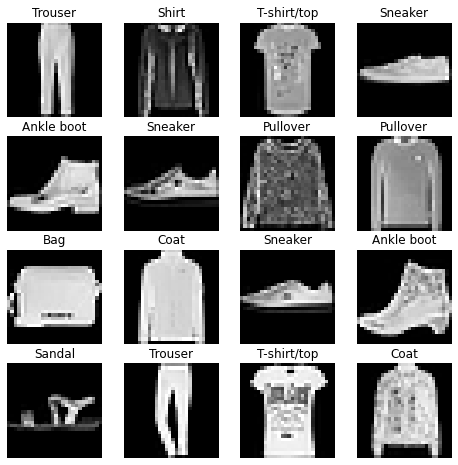

In [5]:
plt.figure(figsize=(8,8))
np.random.seed(SEED)
num_rc = 4
for i in range(16):
    idx = np.random.randint(X.shape[0])
    ax = plt.subplot(num_rc, num_rc, i + 1)
    ax.set_title(CLS_LIST[y[idx]])
    ax.set_axis_off()
    plt.imshow(X[idx].reshape(28,28), cmap='gray', vmin = 0, vmax = 255)

Разделим обучение на train и test

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
# Необходимо дописать пайплайн разделения данных
# : PLACE FOR YOUR CODE :
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

In [8]:
train = y_train

unique, counts = np.unique(train, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)
test = y_test

unique, counts = np.unique(test, return_counts=True)

result = np.column_stack((unique, counts)) 
print (result)

[[   0 5698]
 [   1 5693]
 [   2 5707]
 [   3 5668]
 [   4 5739]
 [   5 5695]
 [   6 5723]
 [   7 5705]
 [   8 5694]
 [   9 5678]]
[[  0 302]
 [  1 307]
 [  2 293]
 [  3 332]
 [  4 261]
 [  5 305]
 [  6 277]
 [  7 295]
 [  8 306]
 [  9 322]]


### Определим классы наших слоев

In [9]:
class Dense:
    # : PLACE FOR YOUR CODE :
    def __init__(self, in_size, out_size):
        self.W = np.random.normal(scale = 0.1, size = (out_size, in_size))
        self.b = np.random.normal(scale = 0.1, size = (out_size))
        
    def forward(self, x):
        self.x = x # для обратного прохода
        # вычисление линейной функции
        return np.dot(self.W, x) + self.b
    
    def backward(self, dz, lr = 0.01):
        # dz - градиент лосс функции
        # вычисляем градиенты по параметрам (для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W)
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.db = self.db - lr * self.db
        # возвращаем dx для дальнейших вычислений
        return self.dx

In [10]:
class ReLu:
    # : PLACE FOR YOUR CODE :
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr = 0.1):
        dz[self.x < 0] = 0
        return dz

In [11]:
class Softmax:
    # : PLACE FOR YOUR CODE :
    def forward(self, x):
        self.x = x 
        exps = np.exp(x - np.amax(x))
        return exps / np.sum(exps)
    
    def backward(self, dz, lr = 0.01):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [12]:
class CrossEntropy:
    # : PLACE FOR YOUR CODE :
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum(y_true * np.log(y_hat))
    
    def backward(self, dz, lr = 0.01):
        return dz * -1. * self.y_true / self.y_hat

Соберем сеть для классификации изображений

In [13]:
class FashionMnistNet:
    # : PLACE FOR YOUR CODE :
    def __init__(self):
        # 1 слой
        self.d1 = Dense(784,392)
        self.a1 = ReLu()
        # 2 слой
        self.d2 = Dense(392, 196)
        self.a2 = ReLu()
        # 3 слой
        #self.d3 = Dense(196, 196)
        #self.a3 = ReLu()
        # 4 слой
        self.d3 = Dense(196, 10)
        self.sm = Softmax()
    
    def forward(self, x):
        # 1 слой
        net = self.d1.forward(x)
        net = self.a1.forward(net)
        # 2 слой
        net = self.d2.forward(net)
        net = self.a2.forward(net)
        # 3 слой
        #net = self.d3.forward(net)
        #net = self.a3.forward(net)
        # 4 слой
        net = self.d3.forward(net)
        net = self.sm.forward(net)
        
        self.net = net
        return net
    
    def backward(self, dz, lr = 0.001):
        # 4 слой
        dz = self.sm.backward(dz, lr)
        dz = self.d3.backward(dz, lr)
        # 3 слой
        #dz = self.a3.backward(dz, lr)
        #dz = self.d3.backward(dz, lr)
        # 2 слой
        dz = self.a2.backward(dz, lr)
        dz = self.d2.backward(dz, lr)
        # 1 слой
        dz = self.a1.backward(dz, lr)
        dz = self.d1.backward(dz, lr)
        return dz

Предобработаем наши данные

In [14]:
# тут необходимо дописать базовую предобработку датасета
def preproc(data):
    data = data.astype("float")
    dataMean = np.mean(data, axis = 0)
    dataStd = np.std(data, axis = 0)
    data = (data - dataMean) / (dataStd + 0.0001)
    return data

X_train_mod = preproc(X_train)
X_test_mod = preproc(X_test)
X_val_mod = preproc(X_val)

In [15]:
# заэнкодим наши ответы
t = OneHotEncoder(sparse=False)
y_train_oh = t.fit_transform(y_train.reshape(-1,1))
y_test_oh = t.fit_transform(y_test.reshape(-1,1))

In [16]:
net = FashionMnistNet()

In [17]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pylab

np.random.seed(SEED)
NUM_EPOCH = 15
list_of_lr = [0.01, 0.008, 0.006, 0.004, 0.002, 0.0015, 0.0005, 0.0001]
lr_pos_index = 0
lr = list_of_lr[lr_pos_index]
L_train_acc = [] # массив для хранения лоссов на обучении за эпоху
L_test_acc = [] # массив для хранения лоссов на отложенном сете
Acc_test_acc = [] # массив для хранения точности на отложенном сете за эпоху

Acc_to_stop = 0.95

loss = CrossEntropy()

for epoch in tqdm(range(NUM_EPOCH)):
    # ЧАСТЬ 1:
    # проводим эпоху обучения, сохраняем средний лосс по всем примерам за эпоху
    # в переменной L_train_acc
    # : PLACE FOR YOUR CODE :
    L_acc = 0.
    sh = list(range(X_train_mod.shape[0]))
    np.random.shuffle(sh)
    # идем по всем тренировочным данным 
    for i in range(int(X_train_mod.shape[0])):
        # запоминаем пример
        x = X_train_mod[sh[i]]
        # запоминаем его ответ
        y = y_train_oh[sh[i]]
        # прогоняем наш X по сети и получаем выход из сети
        y_h = net.forward(x)
        # считаем лосс
        L = loss.forward(y, y_h)
        L_acc += L
        # идем обратно (считаем градиенты)
        dz = loss.backward(1, lr)
        dz = net.backward(dz, lr)
    
    print("train loss: ", L_acc / X_train_mod.shape[0])
    L_train_acc.append(L_acc / X_train_mod.shape[0])
    # ЧАСТЬ 2:
    # Оцениваем сеть после одной эпохи на отложенной выборке
    # Сохраняем средний лосс в переменной L_test_acc
    # Сохраняем среднее значение accuracy в Acc_test_acc
    # : PLACE FOR YOUR CODE :
    pred = []
    L_acc = 0.
    y_true = []
    for i in range(X_test_mod.shape[0]):
        x = X_test_mod[i]
        # запоминаем его ответ
        y = y_test_oh[i]
        # прогоняем наш X по сети и получаем выход из сети
        y_h = net.forward(x)
        # считаем лосс
        L = loss.forward(y, y_h)
        L_acc += L
        # запоминаем ответ модели
        pred.append(np.argmax(y_h, axis=0))
        y_true.append(np.argmax(y))
    
    print("test loss: ", L_acc / X_test_mod.shape[0])
    L_test_acc.append(L_acc / X_test_mod.shape[0])
    # считаем accuracy после эпохи
    Acc_test_acc.append(accuracy_score(y_true, pred))
    print("acc: ", Acc_test_acc[epoch])
    # заканичваем обучение, как достигли желаемого качества
    if Acc_test_acc[-1] >= Acc_to_stop:
        break
    # уменьшаем lr, когда начал расти loss
    if len(L_test_acc) > 1:
        if (L_test_acc[-1] >= L_test_acc[-2]) and (lr_pos_index + 1 != len(list_of_lr)):
            lr_pos_index += 1
            lr = list_of_lr[lr_pos_index]

  0%|          | 0/15 [00:00<?, ?it/s]

train loss:  0.6516327388897315
test loss:  0.5968853483367224
acc:  0.807
train loss:  0.5755864985579117
test loss:  0.5086131201626667
acc:  0.8486666666666667
train loss:  0.5587115189697729
test loss:  0.6376017330600797
acc:  0.8103333333333333
train loss:  0.44734118011270046
test loss:  0.4006463591119563
acc:  0.866
train loss:  0.40554205241951136
test loss:  0.40600467711256905
acc:  0.8736666666666667
train loss:  0.322067442076749
test loss:  0.4103211600252505
acc:  0.868
train loss:  0.244584294171736
test loss:  0.38063450618137773
acc:  0.8856666666666667
train loss:  0.2149711428258133
test loss:  0.37693736096690456
acc:  0.887
train loss:  0.19754235954728835
test loss:  0.4022824944445627
acc:  0.886
train loss:  0.15151999754108822
test loss:  0.359483163094114
acc:  0.8946666666666667
train loss:  0.13199303080250546
test loss:  0.4096949145824646
acc:  0.8896666666666667
train loss:  0.11399677826269039
test loss:  0.4016769610550231
acc:  0.8963333333333333
tra

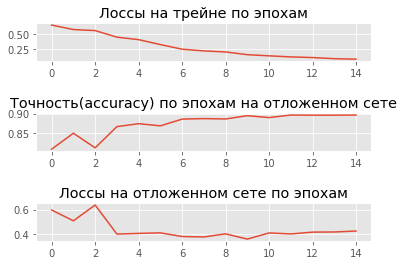

In [18]:
# Выводим 2 графика : 
# 1) Лоссы на трейне и отложенном сете по эпохам
# 2) Точность(accuracy) по эпохам на отложенном сете
# : PLACE FOR YOUR CODE :

plt.style.use('ggplot')

# Две строки, два столбца. Текущая ячейка - 1
pylab.subplot (5, 1, 1)
pylab.plot(list(range(NUM_EPOCH)), L_train_acc)
pylab.title ("Лоссы на трейне по эпохам")

# Две строки, два столбца. Текущая ячейка - 3
pylab.subplot (5, 1, 3)
pylab.plot(list(range(NUM_EPOCH)), Acc_test_acc)    #plot (xlist, ylist)
pylab.title ("Точность(accuracy) по эпохам на отложенном сете")

# Две строки, два столбца. Текущая ячейка - 2
pylab.subplot (5, 1, 5)
pylab.plot (list(range(NUM_EPOCH)), L_test_acc)
pylab.title ("Лоссы на отложенном сете по эпохам")


# Покажем окно с нарисованным графиком
pylab.show()


In [19]:
# формируем сабмишшен
with open(OUTPUT_FNAME, 'w') as fout: 
    fout.write("Id,Category\n")
    for i, x in tqdm(enumerate(X_val_mod)):
        n_out = net.forward(x)
        fout.write(f"{i},{np.argmax(n_out, axis=0)}\n")

0it [00:00, ?it/s]

In [20]:
Acc_test_acc

[0.807,
 0.8486666666666667,
 0.8103333333333333,
 0.866,
 0.8736666666666667,
 0.868,
 0.8856666666666667,
 0.887,
 0.886,
 0.8946666666666667,
 0.8896666666666667,
 0.8963333333333333,
 0.896,
 0.896,
 0.8963333333333333]

In [21]:
y_test_oh

array([[0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [22]:
pred

[8,
 7,
 8,
 6,
 9,
 4,
 7,
 1,
 4,
 4,
 0,
 4,
 7,
 3,
 4,
 0,
 1,
 1,
 8,
 9,
 4,
 7,
 8,
 8,
 1,
 4,
 0,
 5,
 6,
 0,
 0,
 5,
 7,
 7,
 9,
 9,
 3,
 4,
 1,
 4,
 5,
 5,
 9,
 6,
 2,
 7,
 3,
 5,
 9,
 7,
 7,
 1,
 1,
 5,
 5,
 6,
 9,
 6,
 4,
 8,
 3,
 6,
 4,
 6,
 8,
 5,
 6,
 6,
 6,
 8,
 0,
 8,
 9,
 9,
 8,
 8,
 1,
 0,
 9,
 2,
 9,
 9,
 7,
 3,
 6,
 2,
 9,
 9,
 1,
 4,
 9,
 0,
 9,
 9,
 1,
 1,
 7,
 4,
 7,
 3,
 0,
 1,
 1,
 7,
 1,
 4,
 7,
 4,
 7,
 3,
 5,
 2,
 5,
 8,
 8,
 9,
 4,
 8,
 4,
 8,
 7,
 2,
 8,
 5,
 0,
 6,
 6,
 8,
 3,
 7,
 5,
 4,
 7,
 9,
 3,
 5,
 1,
 0,
 3,
 8,
 9,
 9,
 7,
 9,
 0,
 7,
 3,
 5,
 5,
 0,
 8,
 6,
 3,
 8,
 1,
 5,
 6,
 0,
 4,
 1,
 7,
 9,
 2,
 0,
 9,
 7,
 7,
 3,
 4,
 4,
 4,
 5,
 7,
 5,
 8,
 0,
 1,
 3,
 8,
 7,
 6,
 1,
 6,
 3,
 3,
 7,
 6,
 3,
 0,
 0,
 5,
 2,
 8,
 1,
 5,
 3,
 4,
 1,
 6,
 8,
 2,
 9,
 7,
 9,
 2,
 2,
 5,
 1,
 7,
 1,
 0,
 9,
 1,
 6,
 3,
 4,
 0,
 6,
 8,
 8,
 5,
 3,
 8,
 9,
 4,
 0,
 9,
 7,
 4,
 7,
 5,
 2,
 7,
 5,
 5,
 0,
 5,
 7,
 7,
 4,
 9,
 7,
 3,
 6,
 4,
 3,
 1,
 2,
 8,
 5,
